In [1]:
pip install numpy pandas tensorflow keras scikit-learn matplotlib seaborn

  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf2onnx 1.16.1 requires protobuf~=3.20, but you have protobuf 3.19.6 which is incompatible.
rasa-sdk 3.9.0 requires protobuf==4.25.3, but you have protobuf 3.19.6 which is incompatible.


onnx 1.16.2 requires protobuf>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
grpcio-tools 1.56.2 requires protobuf<5.0dev,>=4.21.6, but you have protobuf 3.19.6 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
match_data = pd.read_csv('filtered_data.csv')
player_data = pd.read_csv('pl_player.csv')

# Process match data
match_data['HomeTeam'] = match_data['HomeTeam'].astype(str)
match_data['AwayTeam'] = match_data['AwayTeam'].astype(str)

# Aggregate player stats per team
team_player_stats = player_data.groupby('Team').agg({
    'Gls': 'sum', 'Ast': 'sum', 'MP': 'sum', 'G+A': 'sum', 'G+A_90': 'mean'
}).reset_index()

# Merge player stats into match data
match_data = match_data.merge(team_player_stats, left_on='HomeTeam', right_on='Team', how='left', suffixes=('', '_home'))
match_data = match_data.merge(team_player_stats, left_on='AwayTeam', right_on='Team', how='left', suffixes=('', '_away'))
match_data.drop(['Team', 'Team_away'], axis=1, inplace=True)

# Normalize numerical columns
scaler = StandardScaler()
match_data[['Gls', 'Ast', 'Gls_away', 'Ast_away']] = scaler.fit_transform(match_data[['Gls', 'Ast', 'Gls_away', 'Ast_away']])


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [3]:
# Convert FullTimeResult to numeric values
def convert_result_to_numeric(result):
    if result == 'H':
        return 1  # Home win
    elif result == 'A':
        return -1  # Away win
    else:
        return 0  # Draw

match_data['FullTimeResult_numeric'] = match_data['FullTimeResult'].apply(convert_result_to_numeric)

# Calculate streaks for both teams
def get_last_5_matches(data, team_column):
    streaks = []
    for i in range(len(data)):
        team_matches = data[data[team_column] == data[team_column].iloc[i]]
        last_5_results = team_matches['FullTimeResult_numeric'].iloc[:i].tail(5)
        streak_factor = np.average(last_5_results, weights=np.arange(1, len(last_5_results) + 1)) if len(last_5_results) > 0 else 0
        streaks.append(streak_factor)
    return streaks

match_data['home_team_streak'] = get_last_5_matches(match_data, 'HomeTeam')
match_data['away_team_streak'] = get_last_5_matches(match_data, 'AwayTeam')

# Final features for the model
final_features = ['HomeTeam', 'AwayTeam', 'Gls', 'Ast', 'home_team_streak', 'away_team_streak']
X = match_data[final_features]
y = (match_data['FullTimeResult'] == 'H').astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure all input features are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Handle NaNs
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Reshape the input to add a time step dimension (sequence_length = 1)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (9448, 1, 6)
X_test shape: (2362, 1, 6)


In [4]:
# Define model
num_features = X_train.shape[2]

input_layer = Input(shape=(1, num_features))
x = Bidirectional(SimpleRNN(64, return_sequences=True))(input_layer)
x = Bidirectional(SimpleRNN(32))(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 6)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 128)           9088      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               10304     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
296/296 [==============================] - 6s 

In [5]:
# Visualization functions
def visualize_streakiness(last_5_results):
    result_counts = {
        'Wins': last_5_results.count('W'),
        'Draws': last_5_results.count('D'),
        'Losses': last_5_results.count('L')
    }

    plt.figure(figsize=(8, 6))
    plt.pie(result_counts.values(), labels=result_counts.keys(), autopct='%1.1f%%', startangle=140)
    plt.title('Streakiness Factor (Last 5 Matches)')
    plt.axis('equal')
    plt.show()

def visualize_goals_scored(goals):
    labels = [f'Match {i+1}' for i in range(len(goals))]
    
    plt.figure(figsize=(8, 6))
    plt.pie(goals, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Goals Scored in Last 5 Matches')
    plt.axis('equal')
    plt.show()

def predict_match_outcome(last_5_home, last_5_away):
    home_wins = last_5_home.count('W')
    away_wins = last_5_away.count('W')
    draws = last_5_home.count('D') + last_5_away.count('D')

    total_matches = len(last_5_home) + len(last_5_away)
    probabilities = {
        'Home Win': home_wins / total_matches,
        'Away Win': away_wins / total_matches,
        'Draw': draws / total_matches
    }

    plt.figure(figsize=(8, 6))
    plt.pie(probabilities.values(), labels=probabilities.keys(), autopct='%1.1f%%', startangle=140)
    plt.title('Predicted Match Outcome Probabilities')
    plt.axis('equal')
    plt.show()


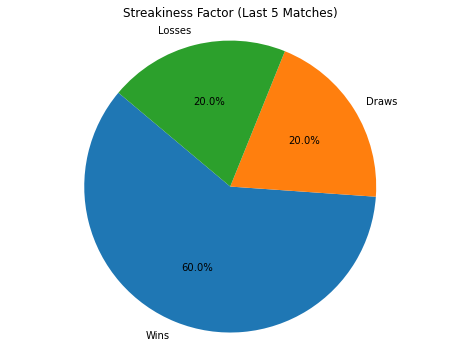

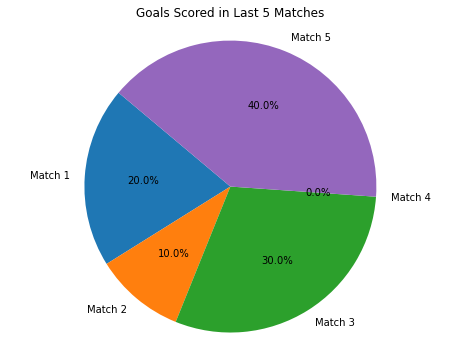

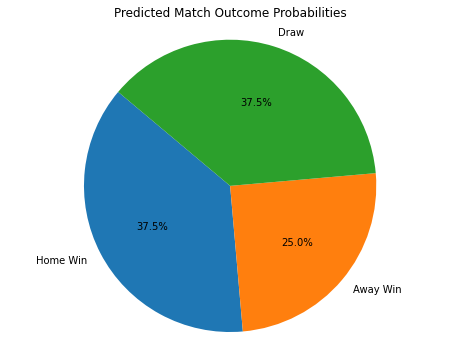

C:\Users\akila\AppData\Local\Temp\ipykernel_27216\1411697018.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


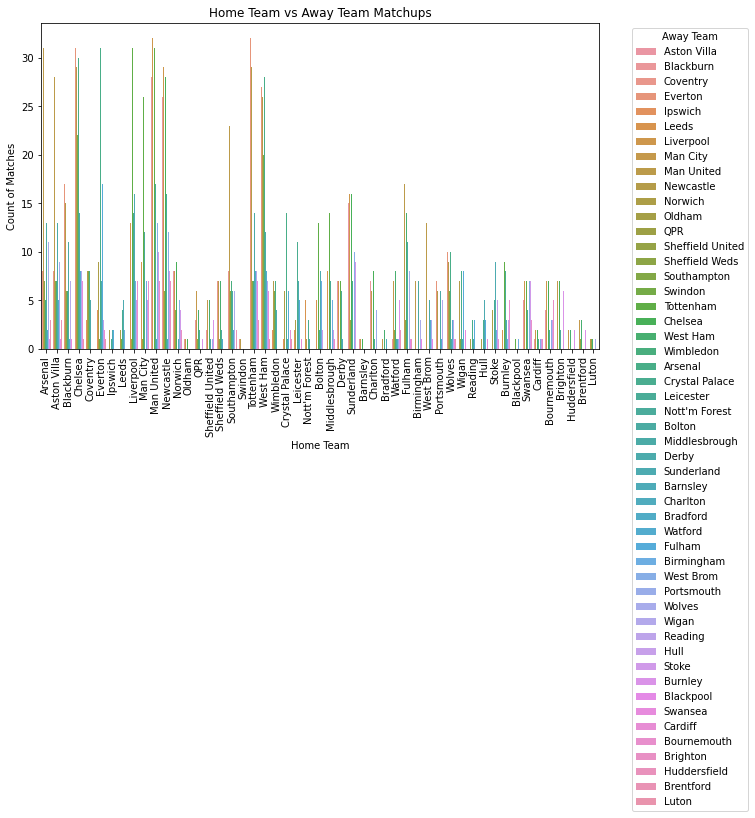

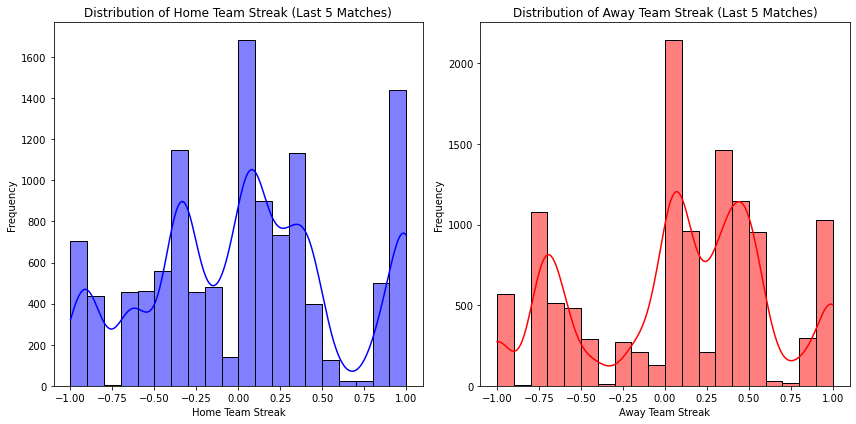

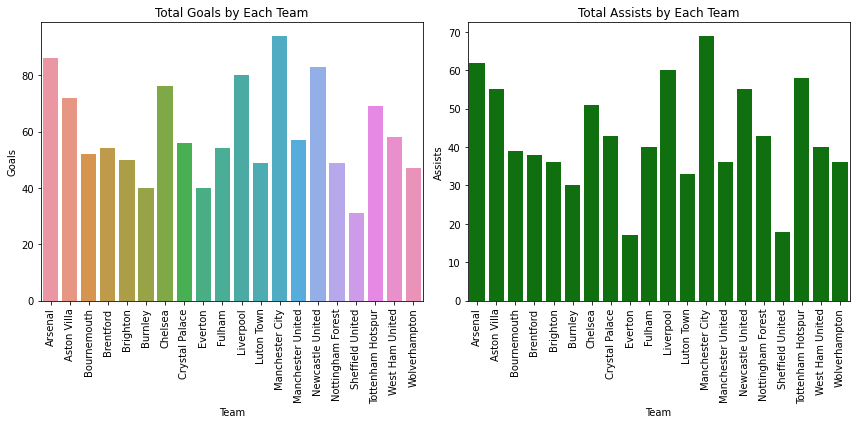

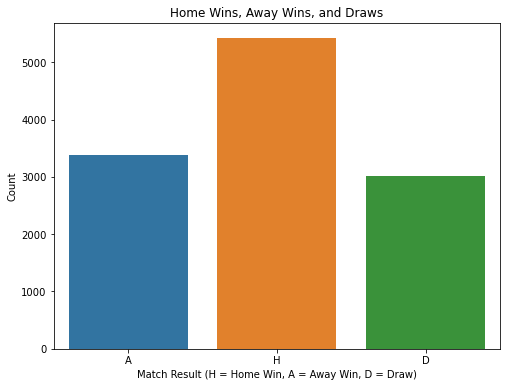

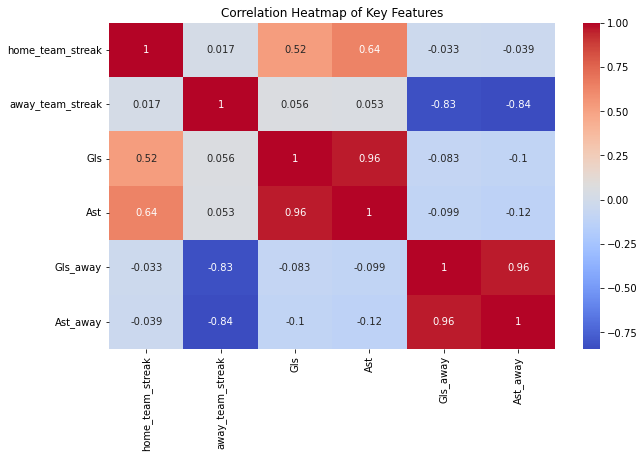

In [6]:
# Example data for visualizations (replace with actual last 5 match data)
home_team_last_5_results = ['W', 'D', 'W', 'W', 'L']
away_team_last_5_results = ['L', 'D', 'W', 'D', 'W']
goals_home = [2, 1, 3, 0, 4]

# Visualize results
visualize_streakiness(home_team_last_5_results)
visualize_goals_scored(goals_home)
predict_match_outcome(home_team_last_5_results, away_team_last_5_results)

# Plot the matchups between Home and Away Teams
plt.figure(figsize=(10, 6))
sns.countplot(data=match_data, x='HomeTeam', hue='AwayTeam')
plt.title('Home Team vs Away Team Matchups')
plt.xticks(rotation=90)
plt.xlabel('Home Team')
plt.ylabel('Count of Matches')
plt.legend(title='Away Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Past form of Home and Away Teams (Last 5 matches streak)
plt.figure(figsize=(12, 6))

# Home team past form
plt.subplot(1, 2, 1)
sns.histplot(match_data['home_team_streak'], bins=20, kde=True, color='blue')
plt.title('Distribution of Home Team Streak (Last 5 Matches)')
plt.xlabel('Home Team Streak')
plt.ylabel('Frequency')

# Away team past form
plt.subplot(1, 2, 2)
sns.histplot(match_data['away_team_streak'], bins=20, kde=True, color='red')
plt.title('Distribution of Away Team Streak (Last 5 Matches)')
plt.xlabel('Away Team Streak')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot the stats of players (Goals, Assists, etc.)
team_stats = player_data.groupby('Team').agg({
    'Gls': 'sum', 'Ast': 'sum', 'MP': 'sum', 'G+A': 'sum', 'G+A_90': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))

# Goals per team
plt.subplot(1, 2, 1)
sns.barplot(data=team_stats, x='Team', y='Gls')
plt.title('Total Goals by Each Team')
plt.xticks(rotation=90)
plt.ylabel('Goals')

# Assists per team
plt.subplot(1, 2, 2)
sns.barplot(data=team_stats, x='Team', y='Ast', color='green')
plt.title('Total Assists by Each Team')
plt.xticks(rotation=90)
plt.ylabel('Assists')

plt.tight_layout()
plt.show()

# Plot Home vs Away Wins
plt.figure(figsize=(8, 6))
sns.countplot(data=match_data, x='FullTimeResult')
plt.title('Home Wins, Away Wins, and Draws')
plt.xlabel('Match Result (H = Home Win, A = Away Win, D = Draw)')
plt.ylabel('Count')
plt.show()

# Correlation matrix between key parameters
plt.figure(figsize=(10, 6))
sns.heatmap(match_data[['home_team_streak', 'away_team_streak', 'Gls', 'Ast', 'Gls_away', 'Ast_away']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Key Features')
plt.show()


In [7]:
pip install tf2onnx

Note: you may need to restart the kernel to use updated packages.


  Using cached protobuf-3.20.3-cp39-cp39-win_amd64.whl (904 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Anaconda_new\\Lib\\site-packages\\google\\protobuf\\~%ternal\\_api_implementation.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [8]:
import tf2onnx
# Convert and save
model_proto, _ = tf2onnx.convert.from_keras(model)
with open('RNN.onnx', 'wb') as f:
    f.write(model_proto.SerializeToString())

import onnx

onnx_model = onnx.load('RNN.onnx')

# Check the model for any issues
onnx.checker.check_model(onnx_model)
print("The model is valid!")

The model is valid!


In [9]:
import tf2onnx
import os

# Define the directory where you want to save the model
save_directory = 'D:\\Advay_Projects\\Minor_Project_2.0\\Github_Folder_2.0\\Capsule\\RNN'
os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Convert and save the model to the specified directory
model_proto, _ = tf2onnx.convert.from_keras(model)
onnx_model_path = os.path.join(save_directory, 'RNN.onnx')

with open(onnx_model_path, 'wb') as f:
    f.write(model_proto.SerializeToString())

print(f'Model saved to: {onnx_model_path}')

Model saved to: D:\Advay_Projects\Minor_Project_2.0\Github_Folder_2.0\Capsule\RNN\RNN.onnx


In [10]:
# Load the ONNX model
model_path = 'RNN.onnx'
model = onnx.load(model_path)

# Print the model structure (text format)
print(onnx.helper.printable_graph(model.graph))

graph tf2onnx (
  %input_1[FLOAT, unk__669x1x6]
) initializers (
  %new_shape__214[INT64, 3]
  %model/dense/MatMul/ReadVariableOp:0[FLOAT, 64x1]
  %model/dense/BiasAdd/ReadVariableOp:0[FLOAT, 1]
  %model/bidirectional_1/forward_simple_rnn_1/simple_rnn_cell_4/MatMul_1/ReadVariableOp/resource:0[FLOAT, 32x32]
  %model/bidirectional_1/forward_simple_rnn_1/simple_rnn_cell_4/MatMul/ReadVariableOp/resource:0[FLOAT, 128x32]
  %model/bidirectional_1/forward_simple_rnn_1/simple_rnn_cell_4/BiasAdd/ReadVariableOp/resource:0[FLOAT, 32]
  %model/bidirectional_1/backward_simple_rnn_1/time:0[INT32, scalar]
  %model/bidirectional_1/backward_simple_rnn_1/simple_rnn_cell_5/MatMul_1/ReadVariableOp/resource:0[FLOAT, 32x32]
  %model/bidirectional_1/backward_simple_rnn_1/simple_rnn_cell_5/MatMul/ReadVariableOp/resource:0[FLOAT, 128x32]
  %model/bidirectional_1/backward_simple_rnn_1/simple_rnn_cell_5/BiasAdd/ReadVariableOp/resource:0[FLOAT, 32]
  %model/bidirectional/forward_simple_rnn/simple_rnn_cell_1/MatMu